# 📝 Exercise M6.04

The aim of the exercise is to get familiar with the histogram
gradient-boosting in scikit-learn. Besides, we will use this model within a
cross-validation framework in order to inspect internal parameters found via
grid-search.

We will use the California housing dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

First, create a histogram gradient boosting regressor. You can set the trees
number to be large, and configure the model to use early-stopping.

In [3]:
# Write your code here.
from sklearn.ensemble import HistGradientBoostingRegressor

hist_gbr = HistGradientBoostingRegressor(
    max_iter=300,
    early_stopping=True,
    random_state=0
) 
hist_gbr.get_params()

{'categorical_features': None,
 'early_stopping': True,
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 300,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'quantile': None,
 'random_state': 0,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

We will use a grid-search to find some optimal parameter for this model. In
this grid-search, you should search for the following parameters:

* `max_depth: [3, 8]`;
* `max_leaf_nodes: [15, 31]`;
* `learning_rate: [0.1, 1]`.

Feel free to explore the space with additional values. Create the grid-search
providing the previous gradient boosting instance as the model.

In [9]:
# Write your code here.
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 8],
    'max_leaf_nodes': [15, 31],
    'learning_rate': [0.1, 1]
}

grid_cv = GridSearchCV(
    estimator=hist_gbr,
    param_grid=param_grid,
    #scoring="neg_mean_absolute_error",
    n_jobs=2,
    #cv=5
)

Finally, we will run our experiment through cross-validation. In this regard,
define a 5-fold cross-validation. Besides, be sure to shuffle the data.
Subsequently, use the function `sklearn.model_selection.cross_validate` to run
the cross-validation. You should also set `return_estimator=True`, so that we
can investigate the inner model trained via cross-validation.

In [10]:
# Write your code here.
from sklearn.model_selection import cross_validate, KFold

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=0
)

cv_results = cross_validate(
    estimator=grid_cv,
    X=data,
    y=target,
    cv=cv,
    return_estimator=True
)

Now that we got the cross-validation results, print out the mean and standard
deviation score.

In [11]:
# Write your code here.
print(
    "R2 Score with cross validation:"
    f"{-cv_results['test_score'].mean():.03f} ± "
    f"{cv_results['test_score'].std():.03f}"
)

R2 Score with cross validation:-0.837 ± 0.009


Then inspect the `estimator` entry of the results and check the best
parameters values. Besides, check the number of trees used by the model.

In [13]:
# Write your code here.
for estimator in cv_results['estimator']:
    print(f"Best parameters: {estimator.best_params_}")
    print(f"Number of trees: {estimator.best_estimator_.n_iter_}")
    
# ==> should increase max_iter to 1000

Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
Number of trees: 300
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
Number of trees: 300
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
Number of trees: 300
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
Number of trees: 290
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
Number of trees: 300


Inspect the results of the inner CV for each estimator of the outer CV.
Aggregate the mean test score for each parameter combination and make a box
plot of these scores.

In [15]:
# Write your code here.
import pandas as pd

param_columns = [f"param_{name}" for name in param_grid.keys()]
columns = param_columns + ["mean_test_score"]

inner_cv_results = []
for cv_idx, estimator in enumerate(cv_results["estimator"]):
    search_cv_results = pd.DataFrame(estimator.cv_results_)
    search_cv_results = search_cv_results[columns].set_index(param_columns)
    search_cv_results = search_cv_results.rename(
        columns={"mean_test_score": f"CV {cv_idx}"}
    )
    inner_cv_results.append(search_cv_results)
inner_cv_results = pd.concat(inner_cv_results, axis=1).T

inner_cv_results

param_max_depth              3                   8                   3  \
param_max_leaf_nodes        15        31        15        31        15   
param_learning_rate        0.1       0.1       0.1       0.1         1   
CV 0                  0.694474  0.694474  0.695044  0.689567  0.594949   
CV 1                  0.691348  0.691348  0.709519  0.692818  0.635830   
CV 2                  0.699943  0.699943  0.699488  0.689641  0.609780   
CV 3                  0.673540  0.673540  0.686270  0.683081  0.601173   
CV 4                  0.679913  0.679913  0.696454  0.690846  0.621719   

param_max_depth                        8            
param_max_leaf_nodes        31        15        31  
param_learning_rate          1         1         1  
CV 0                  0.594949  0.594929  0.542924  
CV 1                  0.635830  0.574798  0.548045  
CV 2                  0.609780  0.587401  0.557469  
CV 3                  0.601173  0.599924  0.537000  
CV 4                  0.621719  0.586566  0.559147

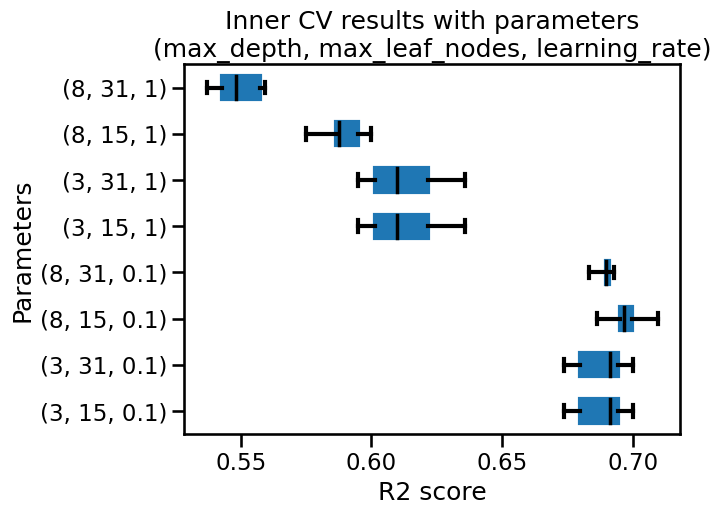

In [16]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title(
    "Inner CV results with parameters\n"
    "(max_depth, max_leaf_nodes, learning_rate)"
)